# Experiments

In [3]:
dataset_name = 'halfmoon'

## Global arguments

In [4]:
import torch
import argparse
import numpy as np
import torch.optim as optim
import torch.nn as nn
import sklearn
from kcenter import make_all_dists, greedy_kcenter, gonzalez_kcenter, CenterObjective, make_dists_igraph, rounding
from models import GCNLink, GCNClusterNet, GCNDeep, GCNDeepSigmoid, GCN
from utils import make_normalized_adj, negative_sample, edge_dropout, load_nofeatures, accuracy, calculate_accuracy
from modularity import baseline_spectral, partition, greedy_modularity_communities, make_modularity_matrix
from loss_functions import loss_kcenter, loss_modularity

import matplotlib.pyplot as plt

In [5]:
normalize_features = False
# For some reason the original code provides its own load_data function but uses the
# function from pygcn, which makes some feature normaliztion with sparse matrix.
if(normalize_features):
    from pygcn import load_data
else:
    from utils import load_data

In [6]:
# class Object(object):
#     pass

# args = Object()

class AttrDict(object):
    def __init__(self, d):
        self.__dict__ = d

no_cuda = True

args = AttrDict(dict(
    dataset = dataset_name,
    train_pct = 0.40,
    objective = 'modularity',
    hidden = 50,
    embed_dim = 50,
    dropout = 0.2,
    edge_dropout = 0.2,
    K = 2,
    train_iters = 1001,
    lr = 0.001,
    num_cluster_iter = 1,
    weight_decay = 5e-4,
    pure_opt = True,
    clustertemp = 70,
    kcentertemp = 100,
    kcentermintemp = 0,
    seed = 24,
    negsamplerate = 1,
    cuda = not no_cuda and torch.cuda.is_available(),
    use_igraph = True,
))

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

run_decision = True
run_ts = True
run_gcne2e = True
run_train_only = True
calculate_opt = True
    
pure_opt = args.pure_opt
test_cluster_auc = False

reload_data = True
make_objectives = False
if reload_data:
    make_objectives = True

has_features = True

train_pct = args.train_pct

## Preparations

### Load data

In [7]:
if reload_data:
    if has_features:
        adj_test, features_test, labels, idx_train, idx_val, idx_test = load_data('data/{}/'.format(args.dataset), '{}_test_{:.2f}'.format(args.dataset, train_pct))
        adj_valid, features_valid, labels, idx_train, idx_val, idx_test = load_data('data/{}/'.format(args.dataset), '{}_valid_{:.2f}'.format(args.dataset, train_pct))
        adj_train, features_train, labels, idx_train, idx_val, idx_test = load_data('data/{}/'.format(args.dataset), '{}_train_{:.2f}'.format(args.dataset, train_pct))
    else:
        adj_all, features, labels = load_nofeatures(args.dataset, '')
        features_train = features
        features_test = features
        n = adj_all.shape[0]
        adj_train, features, labels = load_nofeatures(args.dataset, '_train_{:.2f}'.format(train_pct), n)
        adj_test, features, labels = load_nofeatures(args.dataset, '_test_{:.2f}'.format(train_pct), n)
        adj_valid, features, labels = load_nofeatures(args.dataset, '_valid_{:.2f}'.format(train_pct), n)


adj_test = adj_test.coalesce()
adj_valid = adj_valid.coalesce()
adj_train = adj_train.coalesce()
n = adj_train.shape[0]
K = args.K
bin_adj_test = (adj_test.to_dense() > 0).float()
bin_adj_train = (adj_train.to_dense() > 0).float()
m_train = bin_adj_train.sum()
bin_adj_valid = (adj_valid.to_dense() > 0).float()
bin_adj_all = (bin_adj_train + bin_adj_test + bin_adj_valid > 0).float()
adj_all = make_normalized_adj(bin_adj_all.nonzero(), n)
nfeat = features_test.shape[1]

adj_all, features_test, labels, idx_train, idx_val, idx_test = load_data('data/{}/'.format(args.dataset), '{}'.format(args.dataset))
adj_all = adj_all.coalesce()
adj_test = adj_all
bin_adj_all = (adj_all.to_dense() > 0).float()
n = adj_all.shape[0]
K= args.K
nfeat = features_test.shape[1]

Loading halfmoon_test_0.40 dataset...
Loading halfmoon_valid_0.40 dataset...
Loading halfmoon_train_0.40 dataset...
Loading halfmoon dataset...


In [8]:
def plot_if_possible(r=None, print_normalized=False):
    if features_train.shape[1] == 2:
        if normalize_features and not print_normalized:
            x = []
            y = []
            with open("data/%s/%s.content" % (args.dataset, args.dataset)) as ss:
                for line in ss:
                    _, xx, yy, _ = line.split(' ')
                    x.append(float(xx))
                    y.append(float(yy))
        else:
            x = features_train[:,0]
            y = features_train[:,1]
        
        if print_normalized:
            text = " normalized"
        else:
            text = ""
        if r is None:
            plt.scatter(x, y, c=labels, s=5)
            plt.title("The%s dataset with true labels" % text)
        else:
            predictions = r.argmax(dim=1)
            plt.scatter(x, y, c=predictions, s=5)
            plt.title("The%s dataset with predicted labels" % text)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

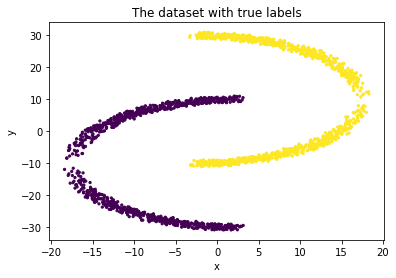

In [9]:
plot_if_possible()

In [10]:
if normalize_features:
    plot_if_possible(print_normalized=True)

### Initialize models

In [11]:
model_ts = GCNLink(nfeat=nfeat,
            nhid=args.hidden,
            nout=args.embed_dim,
            dropout=args.dropout)

model_cluster = GCNClusterNet(nfeat=nfeat,
            nhid=args.hidden,
            nout=args.embed_dim,
            dropout=args.dropout,
            K = args.K,
            cluster_temp = args.clustertemp)

#keep a couple of initializations here so that the random seeding lines up
#with results reported in the paper -- removing these is essentially equivalent to 
#changing the seed
_ = GCN(nfeat, args.hidden, args.embed_dim, args.dropout)
_ = nn.Parameter(torch.rand(K, args.embed_dim))

#uses GCNs to predict the cluster membership of each node
model_gcn = GCNDeep(nfeat=nfeat,
            nhid=args.hidden,
            nout=args.K,
            dropout=args.dropout,
            nlayers=2)

#uses GCNs to predict the probability that each node appears in the solution
model_gcn_x = GCNDeepSigmoid(nfeat=nfeat,
            nhid=args.hidden,
            nout=1,
            dropout=args.dropout,
            nlayers=2)

if args.objective == 'kcenter':
    model_gcn = model_gcn_x



optimizer = optim.Adam(model_cluster.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    model_cluster.cuda()
    model_ts.cuda()
    features = features.cuda()
    adj_train = adj_train.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

losses = []
losses_test = []
num_cluster_iter = args.num_cluster_iter

### Auxilary data for objectives

In [12]:
if make_objectives:
    if args.objective == 'kcenter':
        try:
            dist_all = torch.load('{}_test_dist.pt'.format(args.dataset))
            dist_train = torch.load('{}_{}_train_dist.pt'.format(args.dataset, train_pct))
            diameter = dist_all.max()
        except:
            dist_all = make_all_dists(bin_adj_all, 100)
            diameter = dist_all[dist_all < 100].max()
            dist_all[dist_all == 100] = diameter
            torch.save(dist_all, '{}_test_dist.pt'.format(args.dataset))
            dist_train = make_all_dists(bin_adj_train, 100)
            dist_train[dist_train == 100] = diameter
            torch.save(dist_train, '{}_{}_train_dist.pt'.format(args.dataset, train_pct))
        obj_train = CenterObjective(dist_train, diameter, args.kcentermintemp)
        obj_train_hardmax = CenterObjective(dist_train, diameter, args.kcentermintemp, hardmax=True)
        obj_test = CenterObjective(dist_all, diameter, args.kcentertemp, hardmax=True)
        obj_test_softmax = CenterObjective(dist_all, diameter, args.kcentermintemp)

    if args.objective == 'modularity':
        mod_train = make_modularity_matrix(bin_adj_train)
        mod_test = make_modularity_matrix(bin_adj_test)
        mod_valid = make_modularity_matrix(bin_adj_valid)
        mod_all = make_modularity_matrix(bin_adj_all)

### Define loss functions

In [13]:
if args.objective == 'modularity':
    loss_fn = loss_modularity
    test_object = mod_all
    train_object = mod_train
    test_only_object = mod_test
    valid_object = mod_valid
elif args.objective == 'kcenter':
    loss_fn = loss_kcenter
    test_object= obj_test
    train_object = obj_train
    test_only_object = None
    valid_object = None
else:
    raise Exception('unknown objective')

## Training

### Decision-Focused

ClusterNet value 0.12021000683307648
ClusterNet accuracy:  0.7565


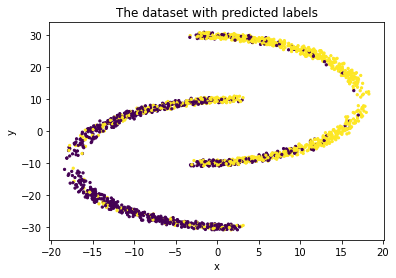

In [14]:
best_train_val = 100
if run_decision:
    for t in range(args.train_iters):
        #pure optimization setting: get loss with respect to the full graph
        if pure_opt:
            mu, r, embeds, dist = model_cluster(features_test, adj_all, num_cluster_iter)
            loss = loss_fn(mu, r, embeds, dist, bin_adj_all, test_object, args)
        #link prediction setting: get loss with respect to training edges only
        else:
            mu, r, embeds, dist = model_cluster(features_train, adj_train, num_cluster_iter)
            loss = loss_fn(mu, r, embeds, dist, bin_adj_train, train_object, args)
        if args.objective != 'kcenter':
            loss = -loss
        optimizer.zero_grad()
        loss.backward()
        #increase number of clustering iterations after 500 updates to fine-tune
        #solution
        if t == 500:
            num_cluster_iter = 5
        #every 100 iterations, look and see if we've improved on the best training loss
        #seen so far. Keep the solution with best training value.
        if t % 100 == 0:
            #round solution to discrete partitioning
            if args.objective == 'modularity':
                r = torch.softmax(100*r, dim=1)
            #evalaute test loss -- note that the best solution is
            #chosen with respect training loss. Here, we store the test loss
            #of the currently best training solution
            loss_test = loss_fn(mu, r, embeds, dist, bin_adj_all, test_object, args)
            #for k-center problem, keep track of the fractional x with best
            #training loss, to do rounding after
            if loss.item() < best_train_val:
                best_train_val = loss.item()
                curr_test_loss = loss_test.item()
                #convert distances into a feasible (fractional x)
                x_best = torch.softmax(dist*args.kcentertemp, 0).sum(dim=1)
                x_best = 2*(torch.sigmoid(4*x_best) - 0.5)
                if x_best.sum() > K:
                    x_best = K*x_best/x_best.sum()
        losses.append(loss.item())
        optimizer.step()

    #for k-center: round 50 times and take the solution with best training
    #value
    if args.objective == 'kcenter':
        testvals = []; trainvals = []
        for _ in range(50):
            y = rounding(x_best)
            testvals.append(obj_test(y).item())
            trainvals.append(obj_train(y).item())
        print('ClusterNet value', testvals[np.argmin(trainvals)])
    if args.objective == 'modularity':
            print('ClusterNet value', curr_test_loss)
            tmp_training_state = model_cluster.training
            model_cluster.training = False
            mu, r, embeds, dist = model_cluster(features_train, adj_train, num_cluster_iter)
            model_cluster.training = tmp_training_state
            print("ClusterNet accuracy: ", accuracy(r, labels).item())
            plot_if_possible(r)

### Two-stages

two stage
0 0.8252480626106262 0.8875307440757751 0.5759628202479339
10 0.6412696242332458 0.698045551776886 0.6060664287190083
20 0.6231847405433655 0.6800824999809265 0.6184574328512397
30 0.6168726682662964 0.681208610534668 0.6189655950413223
40 0.6175939440727234 0.6894094944000244 0.619631208677686
50 0.6094872951507568 0.6959662437438965 0.6197888223140496
60 0.6100767850875854 0.6948980093002319 0.6197973615702479
70 0.6061335206031799 0.6893052458763123 0.6245958088842976
80 0.6031345725059509 0.6864858865737915 0.6263032995867769
90 0.6028876900672913 0.6877791285514832 0.628249964876033
100 0.6002048254013062 0.6864456534385681 0.6313819266528926
110 0.5971616506576538 0.6859597563743591 0.6348067407024793
120 0.5984093546867371 0.6869662404060364 0.637311757231405
130 0.5902552604675293 0.6830838322639465 0.6408929617768595
140 0.5949660539627075 0.6830785870552063 0.643143451446281
150 0.590133011341095 0.6844209432601929 0.6415692758264463
160 0.5863776803016663 0.6858680

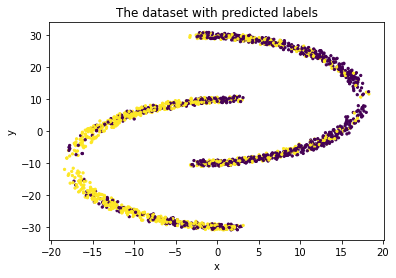

recursive tensor(0.0079)
recursive accuracy:  0.517


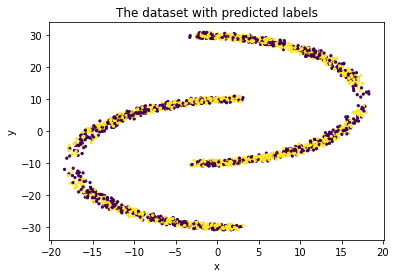

spectral tensor(0.0736)
spectral accuracy:  0.3635


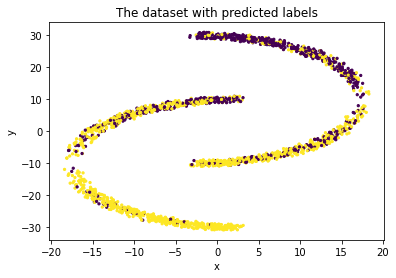

In [15]:
def train_twostage(model_ts):
    optimizer_ts = optim.Adam(model_ts.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)
    edges = adj_train.indices().t()
    edges_test = adj_test.indices().t()
    edges_test_eval, labels_test_eval = negative_sample(edges_test, 1, bin_adj_train)
#    print(edges_test_eval)
    for t in range(300):
        adj_input = make_normalized_adj(edge_dropout(edges, args.edge_dropout), n)
        edges_eval, labels = negative_sample(edges, args.negsamplerate, bin_adj_train)
        preds = model_ts(features_train, adj_input, edges_eval)
        loss = torch.nn.BCEWithLogitsLoss()(preds, labels)
        optimizer_ts.zero_grad()
        loss.backward()
        if t % 10 == 0:
            preds_test_eval = model_ts(features_train, adj_input, edges_test_eval)
            test_ce = torch.nn.BCEWithLogitsLoss()(preds_test_eval, labels_test_eval)
            test_auc = sklearn.metrics.roc_auc_score(labels_test_eval.long().detach().numpy(), nn.Sigmoid()(preds_test_eval).detach().numpy())
            print(t, loss.item(), test_ce.item(), test_auc)
        optimizer_ts.step()

if test_cluster_auc:
    model_linkpred = GCNLink(nfeat=nfeat,
            nhid=args.hidden,
            nout=args.embed_dim,
            dropout=args.dropout)
    model_linkpred.GCN = model_cluster.GCN
    model_linkpred.GCN.requires_grad = False
    train_twostage(model_linkpred)


calculate_ts_performance = False
if run_ts:
    print('two stage')
    train_twostage(model_ts)
    #predict probability that all unobserved edges exist
    indices = torch.tensor(np.arange(n))
    to_pred = torch.zeros(n**2, 2)
    to_pred[:, 1] = indices.repeat(n)
    for i in range(n):
        to_pred[i*n:(i+1)*n, 0] = i
    to_pred = to_pred.long()
    preds = model_ts(features_train, adj_train, to_pred)
    preds = nn.Sigmoid()(preds).view(n, n)

    preds = bin_adj_train + (1 - bin_adj_train)*preds

    if args.objective == 'modularity':
        r = greedy_modularity_communities(preds, K)
        print('agglomerative', loss_fn(None, r, None, None, bin_adj_all, test_object, args))
        print("agglomerative accuracy: ", accuracy(r, labels).item())
        plot_if_possible(r)
        
        r = partition(preds, K)
        print('recursive', loss_fn(None, r, None, None, bin_adj_all, test_object, args))
        print("recursive accuracy: ", accuracy(r, labels).item())
        plot_if_possible(r)

        degrees = preds.sum(dim=1)
        preds = torch.diag(1./degrees)@preds
        mod_pred = make_modularity_matrix(preds)
        r = baseline_spectral(mod_pred, K)
        print('spectral', loss_fn(None, r, None, None, bin_adj_all, test_object, args))
        print("spectral accuracy: ", accuracy(r, labels).item())
        plot_if_possible(r)
    elif args.objective == 'kcenter':
        try:
            dist_ts = torch.load('{}_twostage_dist.pt'.format(args.dataset))
            print('loaded ts dists from {}'.format('{}_twostage_dist.pt'.format(args.dataset)))
        except:
            print('making dists')
            if args.use_igraph:
                print('using igraph')
                dist_ts =  make_dists_igraph(preds)
            else:
                print('using networkx')
                dist_ts = make_all_dists(preds, 100)
                diameter = dist_ts[dist_ts < 100].max()
                dist_ts[dist_ts == 100] = diameter
            print('made dists')
            torch.save(dist_ts, '{}_twostage_dist.pt'.format(args.dataset))
        dist_ts = dist_ts.float()
        diameter = dist_ts.max()
        x = gonzalez_kcenter(dist_ts, K)
        print('gonzalez ts', obj_train_hardmax(x), obj_test(x))
        print(dist_ts.type(), diameter.type())
        x = greedy_kcenter(dist_ts, diameter, K)
        print('greedy ts', obj_train_hardmax(x), obj_test(x))

### E2E GCN

just GCN
0 -0.03433059900999069 0.03535061702132225 0.032009318470954895
100 -0.03394690901041031 0.03465673699975014 0.03207247331738472
200 -0.039161648601293564 0.03938136622309685 0.03889745846390724
300 -0.03346221521496773 0.034480173140764236 0.03198240324854851
400 -0.03533211722970009 0.03306465595960617 0.029239840805530548
500 -0.03449650853872299 0.035713568329811096 0.03359212726354599
600 -0.02648063190281391 0.030436601489782333 0.02794128656387329
700 -0.03940263390541077 0.04028361290693283 0.037852153182029724
800 -0.034923799335956573 0.035552773624658585 0.033156704157590866
900 -0.028511373326182365 0.02855011448264122 0.02509929984807968
train min 0.04028361290693283
e2e gcn accuracy:  0.5965


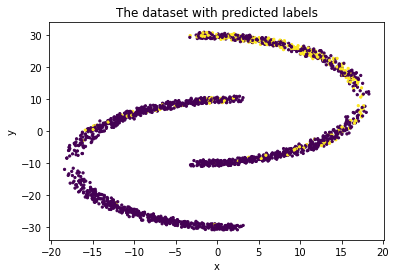

In [16]:
if run_gcne2e:
    print('just GCN')
    optimizer_gcn = optim.Adam(model_gcn.parameters(), lr = args.lr,
                               weight_decay = args.weight_decay)
    if args.objective == 'modularity':
        best_train_val = 0
    if args.objective == 'kcenter':
        best_train_val = 100

    for t in range(1000):
        best_train_loss = 100
        if pure_opt:
            if args.objective == 'modularity' or args.objective == 'maxcut':
                r = model_gcn(features_test, adj_all)
                r = torch.softmax(args.clustertemp*r, dim = 1)
                loss = -loss_fn(None, r, None, None, bin_adj_train, train_object, args)
            elif args.objective == 'kcenter' or args.objecive == 'influmax':
                x = model_gcn(features_test, adj_all)
                if x.sum() > K:
                    x = K*x/x.sum()
                loss = -test_object(x)
        else:
            if args.objective == 'modularity' or args.objective == 'maxcut':
                r = model_gcn(features_train, adj_train)
                r = torch.softmax(r, dim = 1)
                loss = -loss_fn(None, r, None, None, bin_adj_train, train_object, args)
            elif args.objective == 'kcenter' or args.objecive == 'influmax':
                x = model_gcn(features_train, adj_train)
                if x.sum() > K:
                    x = K*x/x.sum()
                loss = -train_object(x)
        if args.objective == 'kcenter':
            loss = -loss
        optimizer.zero_grad()
        loss.backward()
        if t % 100 == 0:
            if args.objective == 'modularity' or args.objective == 'maxcut':
                r = torch.softmax(100*r, dim=1)
                loss_test = loss_fn(None, r, None, None, bin_adj_all, test_object, args)
                loss_test_only = loss_fn(None, r, None, None, bin_adj_test, test_only_object, args)
            elif args.objective == 'kcenter' or args.objecive == 'influmax':
                loss_test = -test_object(x)
                loss_test_only = torch.tensor(0).float()
            losses_test.append(loss_test.item())
            print(t, loss.item(), loss_test.item(), loss_test_only.item())
            if loss.item() < best_train_val:
                curr_test_loss = loss_test.item()
                best_train_val = loss.item()
                if args.objective == 'kcenter' or args.objective == 'influmax':
                    x_best = x
        losses.append(loss.item())
        optimizer.step()
    if args.objective == 'kcenter':
        from influmax import rounding
        testvals = []; trainvals = []; trainvalshardmax = []
        for _ in range(50):
            y = rounding(x_best)
            testvals.append(obj_test(y).item())
            trainvals.append(obj_train(y).item())
            trainvalshardmax.append(obj_train_hardmax(y).item())
        print('train min', testvals[np.argmin(trainvals)])
        print('hardmax train min', testvals[np.argmin(trainvalshardmax)])
        print('absolute min', min(testvals))
    if args.objective == 'modularity':
        print('train min', curr_test_loss)
        print("e2e gcn accuracy: ", accuracy(r, labels).item())
        plot_if_possible(r)

### Train-only baseline

2
agglomerative tensor(-6.6548e-05)
agglomerative accuracy:  0.504


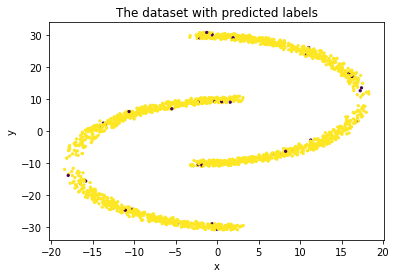

recursive tensor(0.0950)
recursive accuracy:  0.517


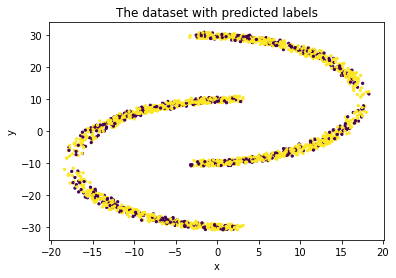

spectral tensor(0.0016)
spectral accuracy:  0.4965


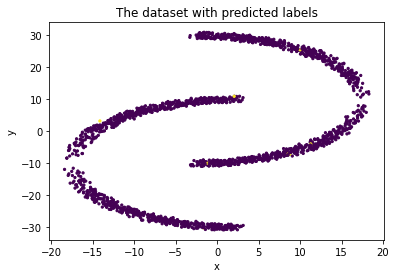

In [17]:
if run_train_only:
    if args.objective == 'modularity':
        preds = bin_adj_train
        r = greedy_modularity_communities(preds, K)
        print('agglomerative', loss_fn(None, r, None, None, bin_adj_all, test_object, args))
        print("agglomerative accuracy: ", accuracy(r, labels).item())
        plot_if_possible(r)

        r = partition(preds, K)
        print('recursive', loss_fn(None, r, None, None, bin_adj_all, test_object, args))
        print("recursive accuracy: ", accuracy(r, labels).item())
        plot_if_possible(r)
        
        degrees = preds.sum(dim=1)
        preds = torch.diag(1./degrees)@preds
        mod_pred = make_modularity_matrix(preds)
        r = baseline_spectral(mod_pred, K)
        print('spectral', loss_fn(None, r, None, None, bin_adj_all, test_object, args))
        print("spectral accuracy: ", accuracy(r, labels).item())
        plot_if_possible(r)
    elif args.objective == 'kcenter':
        x = gonzalez_kcenter(dist_train, K)
        print('gonzalez train', obj_test(x))
        x = greedy_kcenter(dist_train, diameter, K)
        print('greedy train', obj_test(x))

### Baseline optimization algorithms on full graph

2
agglomerative tensor(0.1346)
agglomerative accuracy:  0.494


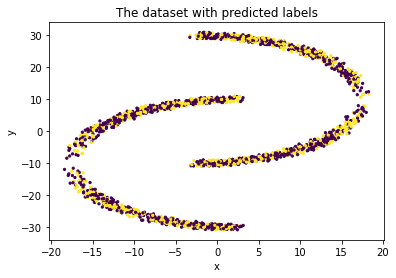

recursive tensor(0.1809)
recursive accuracy:  0.512


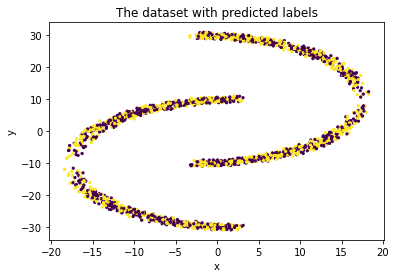

spectral tensor(0.0066)
spectral accuracy:  0.4975


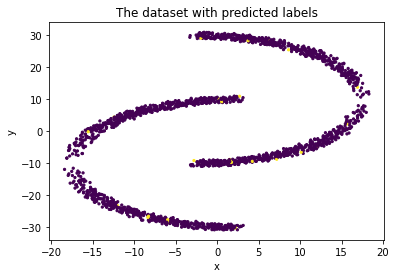

In [18]:
if calculate_opt:
    if args.objective == 'modularity':
        preds = bin_adj_all
        r = greedy_modularity_communities(preds, K)
        print('agglomerative', loss_fn(None, r, None, None, bin_adj_all, test_object, args))
        print("agglomerative accuracy: ", accuracy(r, labels).item())
        plot_if_possible(r)
        
        r = partition(preds, K)
        print('recursive', loss_fn(None, r, None, None, bin_adj_all, test_object, args))
        print("recursive accuracy: ", accuracy(r, labels).item())
        plot_if_possible(r)

        degrees = preds.sum(dim=1)
        preds = torch.diag(1./degrees)@preds
        mod_pred = make_modularity_matrix(preds)
        r = baseline_spectral(mod_pred, K)
        print('spectral', loss_fn(None, r, None, None, bin_adj_all, test_object, args))
        print("spectral accuracy: ", accuracy(r, labels).item())
        plot_if_possible(r)
    elif args.objective == 'kcenter':
        x = gonzalez_kcenter(dist_all, K)
        print('gonzalez all', obj_test(x))
        x = greedy_kcenter(dist_all, diameter, K)
        print('greedy all', obj_test(x))